In [ ]:
# 1. Import Python libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

import glob as glob

In [8]:
# 2. Import the dataset

acl_train = pd.read_csv("dataset/train-acl.csv")
acl_valid = pd.read_csv("dataset/valid-acl.csv")
acl_data = pd.concat([acl_train, acl_valid], ignore_index = True)

meniscus_train = pd.read_csv("dataset/train-meniscus.csv")
meniscus_valid = pd.read_csv("dataset/valid-meniscus.csv")
meniscus_data = pd.concat([meniscus_train, meniscus_valid], ignore_index = True)

abnormal_train = pd.read_csv("dataset/train-abnormal.csv")
abnormal_valid = pd.read_csv("dataset/valid-abnormal.csv")
abnormal_data = pd.concat([abnormal_train, abnormal_valid], ignore_index = True)

In [9]:
acl_data

,case_study,result
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
1245,1245,1
1246,1246,1
1247,1247,0
1248,1248,1


In [10]:
meniscus_data

,case_study,result
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0
...,...,...
1245,1245,1
1246,1246,1
1247,1247,1
1248,1248,1


In [11]:
abnormal_data

,case_study,result
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
1245,1245,1
1246,1246,1
1247,1247,1
1248,1248,1


In [17]:
train_dir = 'dataset/train'
valid_dir = 'dataset/valid'

planes = ['axial', 'coronal', 'sagittal']
datasets = {'train': train_dir, 'valid': valid_dir}

for dataset, path in datasets.items():
    print(f'\nNumber of exams in {dataset} set:')
    for plane in planes:
        print(plane, len(glob.glob(f'{path}/{plane}/*.npy')))


Number of exams in train set:
axial 1130
coronal 1130
sagittal 1130

Number of exams in valid set:
axial 120
coronal 120
sagittal 120


In [20]:
# View the first 5 sagittal exams in the training set

train_sagittal_exams = glob.glob(f'{train_dir}/sagittal/*.npy')[:5]

for exam in train_sagittal_exams:
    series = np.load(exam)
    print(series.shape)

(36, 256, 256)
(26, 256, 256)
(32, 256, 256)
(30, 256, 256)
(32, 256, 256)


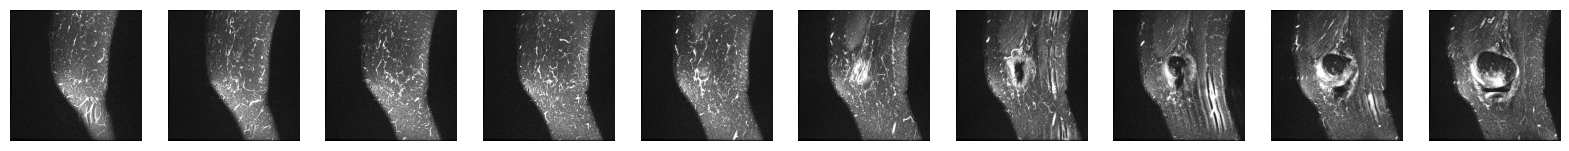

In [21]:
def plot_first_ten(path):
    series = np.load(path)[:10]

    fig = plt.figure(figsize=(20, 6))
    
    for i, image in enumerate(series):
        ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
        plt.imshow(image, cmap='gray')
        plt.axis('off')

plot_first_ten(train_sagittal_exams[0])

## Functions

Taken from GitHub

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms

class MRNetDataset(Dataset):
    def __init__(self, dataset_dir, labels_path, plane, transform=None, device=None):
        self.case_paths = sorted(glob(f'{dataset_dir}/{plane}/**.npy'))
        self.labels_df = pd.read_csv(labels_path)
        self.transform = transform
        self.window = 7
        self.device = device
        if self.device is None:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def make_dataset(data_dir, dataset_type, plane, device=None):
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'

        dataset_dir = f'{data_dir}/{dataset_type}'
        labels_path = f'{data_dir}/{dataset_type}_labels.csv'

        if dataset_type == 'train':
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomAffine(25, translate=(0.1, 0.1)),
                transforms.ToTensor()
            ])
        elif dataset_type == 'valid':
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor()
            ])
        else:
            raise ValueError('Dataset needs to be train or valid.')

        dataset = MRNetDataset(dataset_dir, labels_path, plane, transform=transform, device=device)

        return dataset

In [ ]:
import torch
from torch.utils.data import DataLoader

from dataset import make_dataset


def make_data_loader(data_dir, dataset_type, plane, device=None, shuffle=False):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    dataset = make_dataset(data_dir, dataset_type, plane, device=device)
    data_loader = DataLoader(dataset, batch_size=1, shuffle=shuffle)

    return data_loader